<a href="https://colab.research.google.com/github/Hash2402/CV_Project2-Part1/blob/master/BallDetectionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ball Detection Transformer
This notebook is based on https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/object_detection_using_vision_transformer.ipynb

The dataset is from https://universe.roboflow.com/eagle-eye/basketball-1zhpe/dataset/1

In [ ]:
#@title Install Packages
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
#@title Imports
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]

import tensorflow as tf
import numpy as np
import keras
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil
import json
from tqdm import tqdm

In [ ]:
#@title Download Dataset
from roboflow import Roboflow
rf = Roboflow(api_key="ENxd4LnbAEDiDWQ0ssom")
project = rf.workspace("eagle-eye").project("basketball-1zhpe")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Basketball-1 in yolov8:: 100%|██████████| 5210/5210 [00:00<00:00, 6745.73it/s]


In [ ]:
#@title Dataset Variables
DATASET_DIR = 'Basketball-1'
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
TEST_DIR = os.path.join(DATASET_DIR, 'test')
VAL_DIR = os.path.join(DATASET_DIR, 'valid')
SPLITS = [TRAIN_DIR, TEST_DIR, VAL_DIR]
IMAGE_SIZE = 224
LOG_DIR = 'logs'

In [ ]:
#@title Prepare Dataset

x_data = []
y_data = []
# loop over the annotations and images, preprocess them and store in lists
for data_split, split in enumerate(SPLITS):
    x_data.append([])
    y_data.append([])
    for i, image_path in tqdm(enumerate(os.listdir(os.path.join(split, 'images')))):
        annot_path = os.path.join(split, 'labels', image_path[:-4] + '.txt')
        annot = []
        with open(annot_path) as file:
            lines = file.readlines()
            # if len(lines) > 1:
                # print([line[0] for line in lines])
            if not lines:
                continue
            annot = lines[0].strip().split()
        # ignore non-ball annotations
        if annot[0] != '0':
            continue
        annot = [*map(float, annot)]
        annot[0] = int(annot[0])

        top_left_x, top_left_y = annot[2], annot[0]
        bottom_right_x, bottom_right_y = annot[3], annot[1]

        image = keras.utils.load_img(
            os.path.join(split, 'images', image_path),
        )
        (w, h) = image.size[:2]

        image = image.resize((IMAGE_SIZE, IMAGE_SIZE))

        x_data[data_split].append(keras.utils.img_to_array(image))

        # apply relative scaling to bounding boxes as per given image and append to list
        y_data[data_split].append(
            (
                float(top_left_x) / (w / IMAGE_SIZE),
                float(top_left_y) / (h / IMAGE_SIZE),
                float(bottom_right_x) / (w / IMAGE_SIZE),
                float(bottom_right_y) / (h / IMAGE_SIZE),
            )
        )

# Convert the list to numpy array, split to train and test dataset
x_train = np.array(x_data[0])
y_train = np.array(y_data[0])
x_test = np.array(x_data[1])
y_test = np.array(y_data[1])
x_val = np.array(x_data[2])
y_val = np.array(y_data[2])
len(x_train), len(x_test), len(x_val), len(y_train), len(y_test), len(y_val)

1997it [00:08, 235.24it/s]
472it [00:01, 261.00it/s]
130it [00:00, 256.29it/s]


(1885, 442, 124, 1885, 442, 124)

## Implement multilayer-perceptron (MLP)

We use the code from the Keras example
[Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/)
as a reference.

In [ ]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement the patch creation layer

In [ ]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


## Display patches for an input image

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


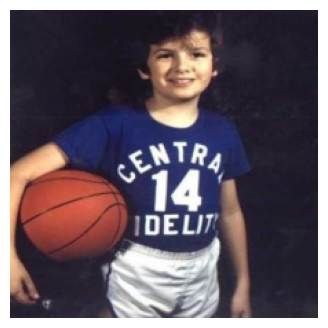

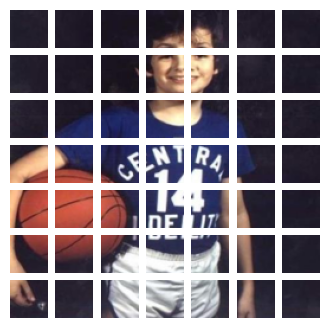

In [ ]:
PATCH_SIZE = 32  # Size of the patches to be extracted from the input images

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(PATCH_SIZE)(np.expand_dims(x_train[0], axis=0))
print(f"Image size: {IMAGE_SIZE} X {IMAGE_SIZE}")
print(f"Patch size: {PATCH_SIZE} X {PATCH_SIZE}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer linearly transforms a patch by projecting it into a
vector of size `projection_dim`. It also adds a learnable position
embedding to the projected vector.

In [ ]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": INPUT_SHAPE,
                "patch_size": PATCH_SIZE,
                "num_patches": NUM_PATCHES,
                "projection_dim": PROJECTION_DIM,
                "num_heads": NUM_HEADS,
                "transformer_units": TRANSFORMER_UNITS,
                "transformer_layers": TRANSFORMER_LAYERS,
                "mlp_head_units": MLP_HEAD_UNITS,
            }
        )
        return config

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded


## Build the ViT model

The ViT model has multiple Transformer blocks.
The `MultiHeadAttention` layer is used for self-attention,
applied to the sequence of image patches. The encoded patches (skip connection)
and self-attention layer outputs are normalized and fed into a
multilayer perceptron (MLP).
The model outputs four dimensions representing
the bounding box coordinates of an object.

In [ ]:

def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = keras.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(4)(
        features
    )  # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)


## Run the experiment

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 132ms/step - loss: 0.4650 - val_loss: 0.0271
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0282 - val_loss: 0.0133
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0148 - val_loss: 0.0094
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0394 - val_loss: 0.0088
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0110 - val_loss: 0.0087
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0103 - val_loss: 0.0086
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0099 - val_loss: 0.0086
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0102 - val_loss: 0.0086
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0101 - val_loss: 0.0086
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0120 - val_loss: 0.0086
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0104 - val_loss: 0.0086
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/st

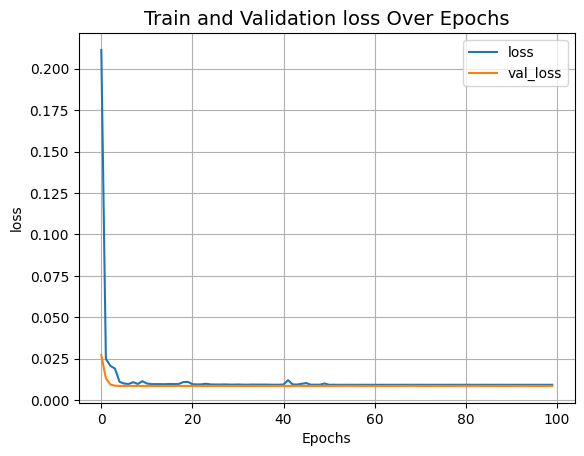

In [ ]:

def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile model.
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

    checkpoint_filepath = "vit_object_detector.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.TensorBoard(log_dir=LOG_DIR),
            # keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ],
    )

    return history


INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
BATCH_SIZE = 32
NUM_EPOCHS = 100
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
PROJECTION_DIM = 64
NUM_HEADS = 4

TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
TRANSFORMER_LAYERS = 4
MLP_HEAD_UNITS = [2048, 1024, 512, 64, 32]


HISTORY = []
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

vit_object_detector = create_vit_object_detector(
    INPUT_SHAPE,
    PATCH_SIZE,
    NUM_PATCHES,
    PROJECTION_DIM,
    NUM_HEADS,
    TRANSFORMER_UNITS,
    TRANSFORMER_LAYERS,
    MLP_HEAD_UNITS,
)

# Train model
history = run_experiment(
    vit_object_detector, LEARNING_RATE, WEIGHT_DECAY, BATCH_SIZE, NUM_EPOCHS
)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")


## Evaluate the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
mean_iou: 0.0


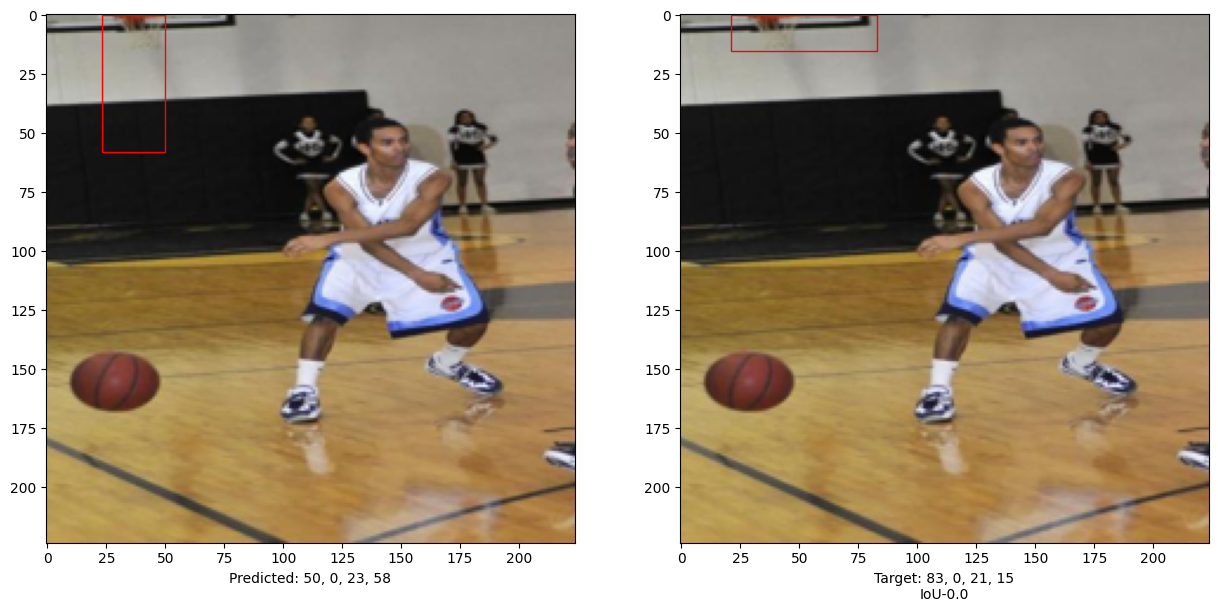

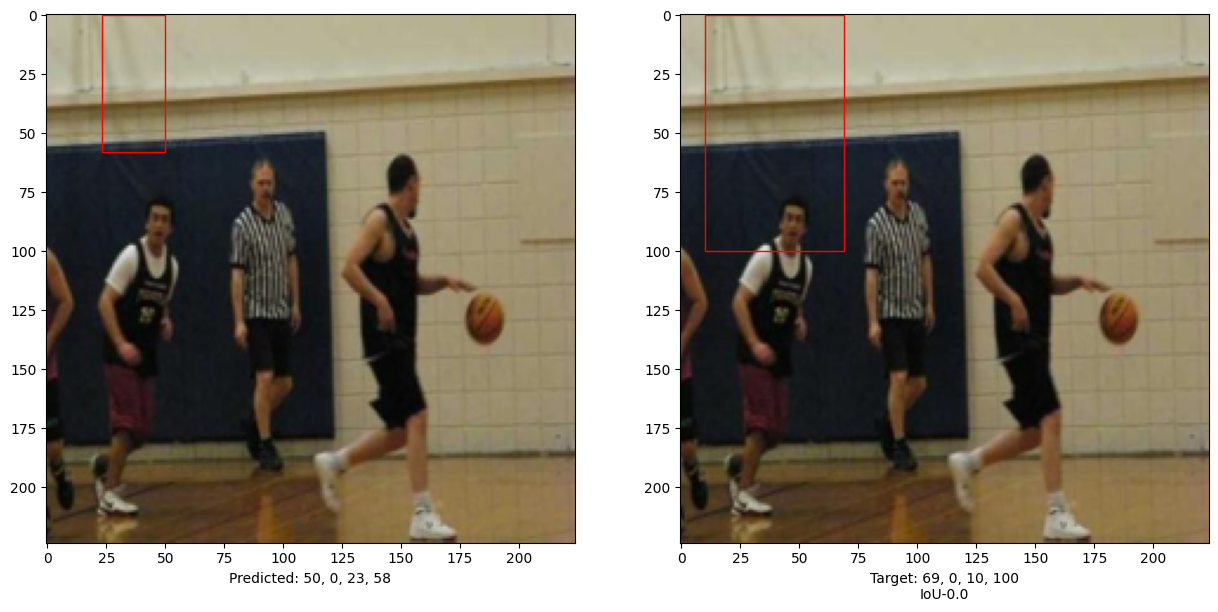

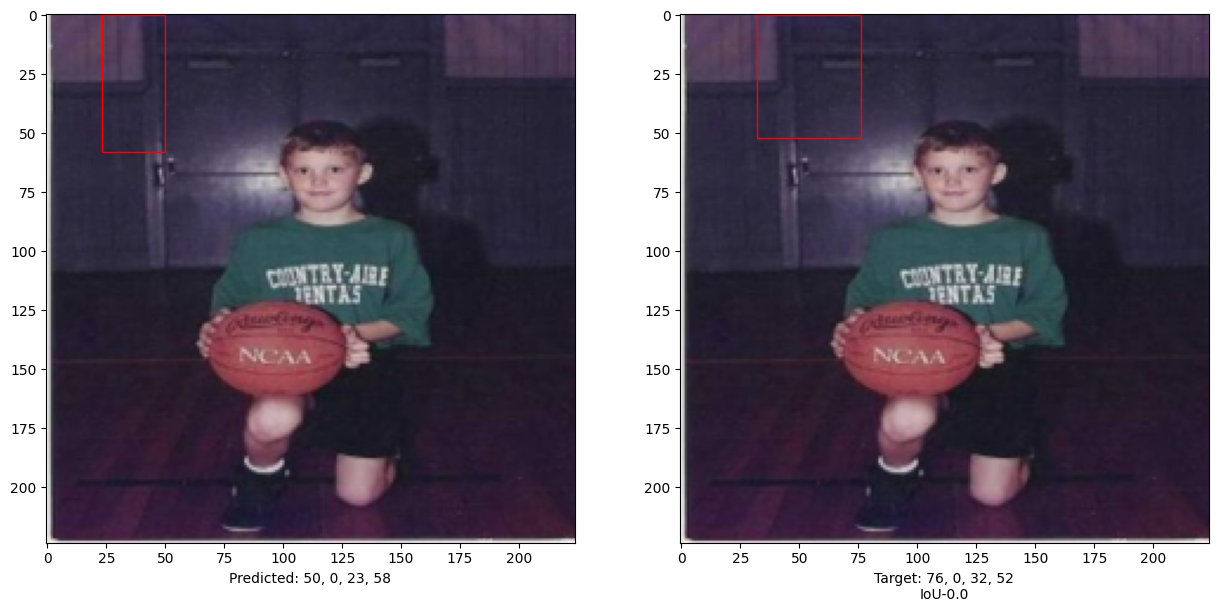

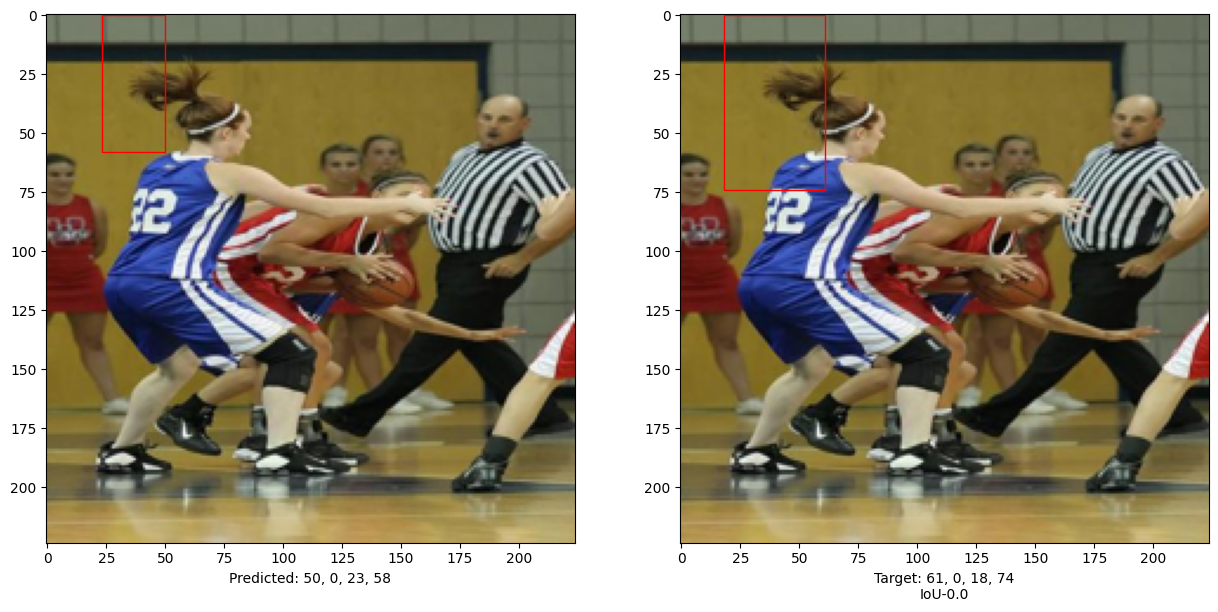

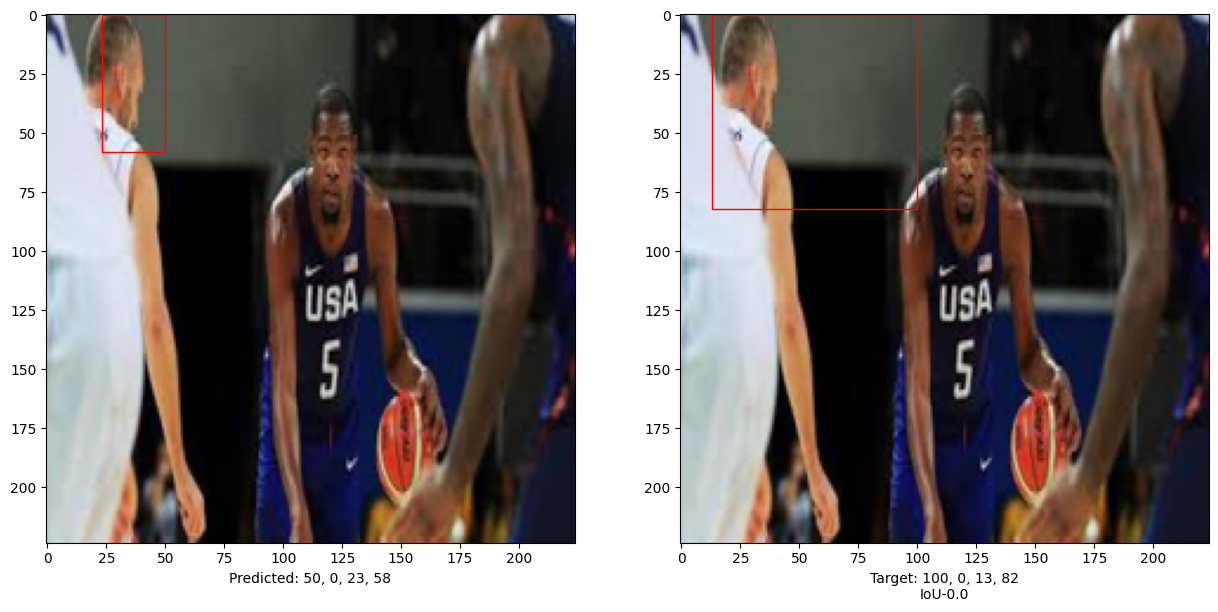

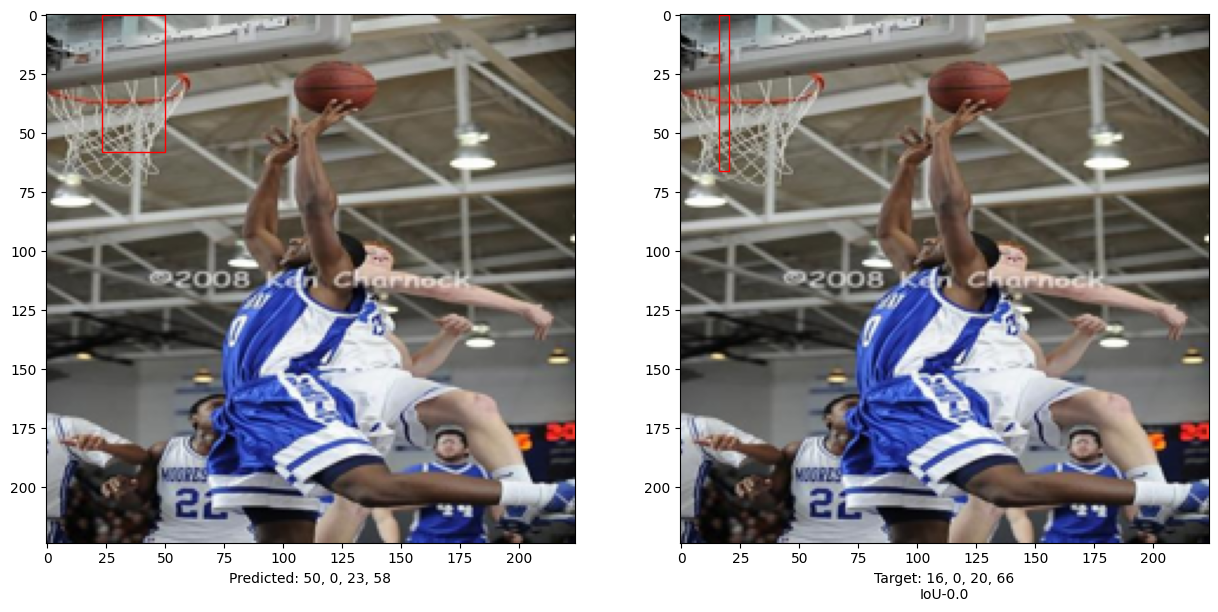

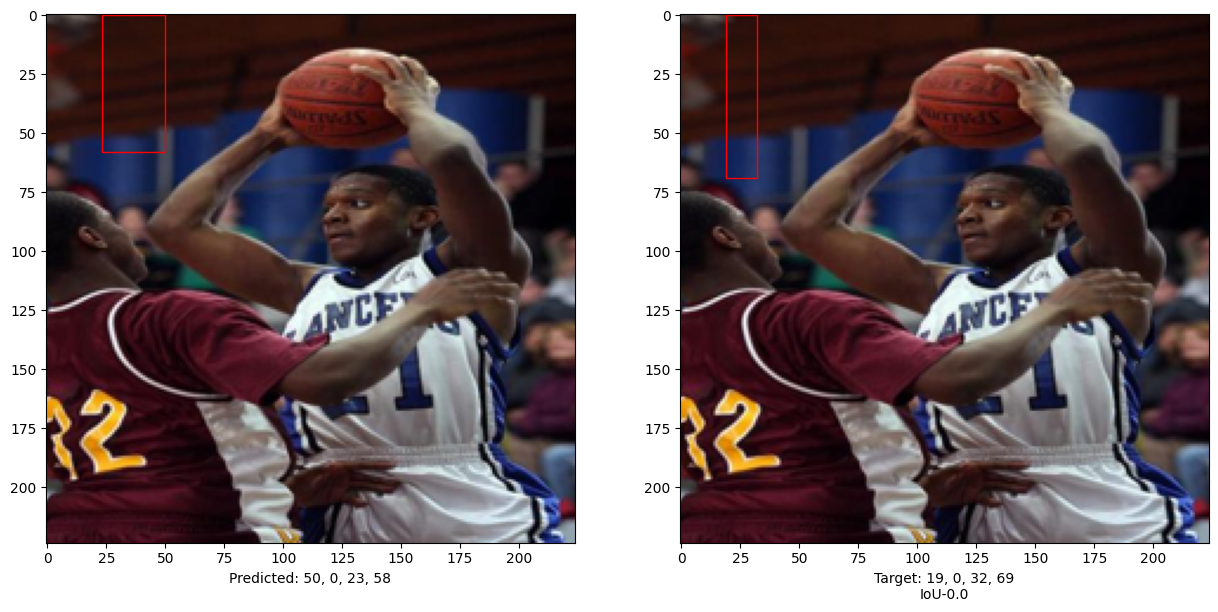

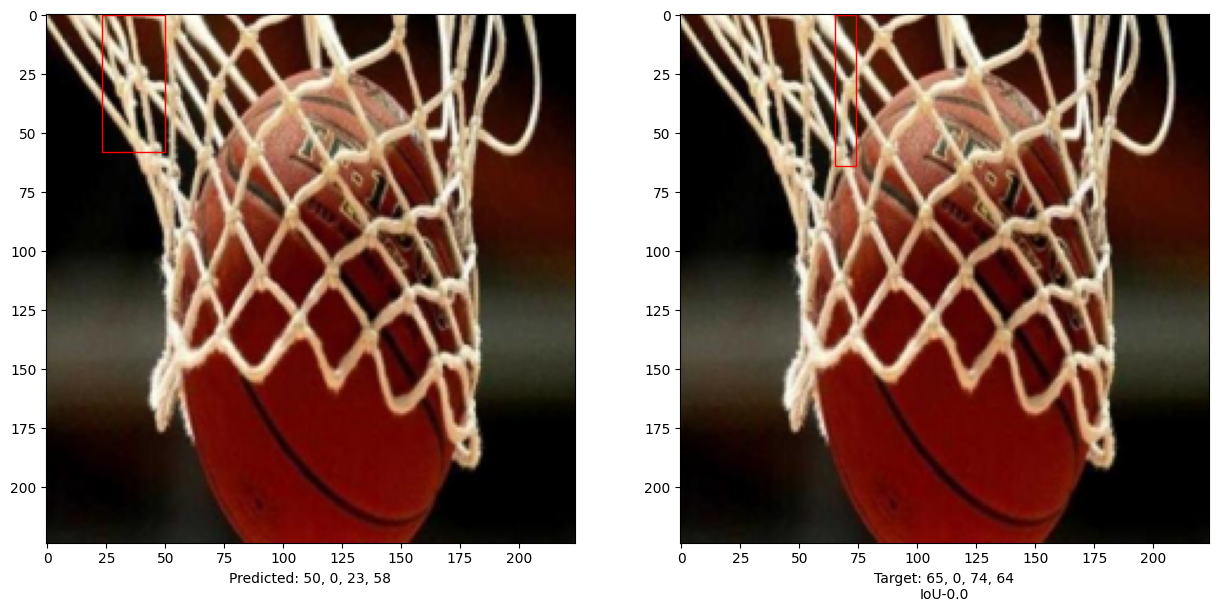

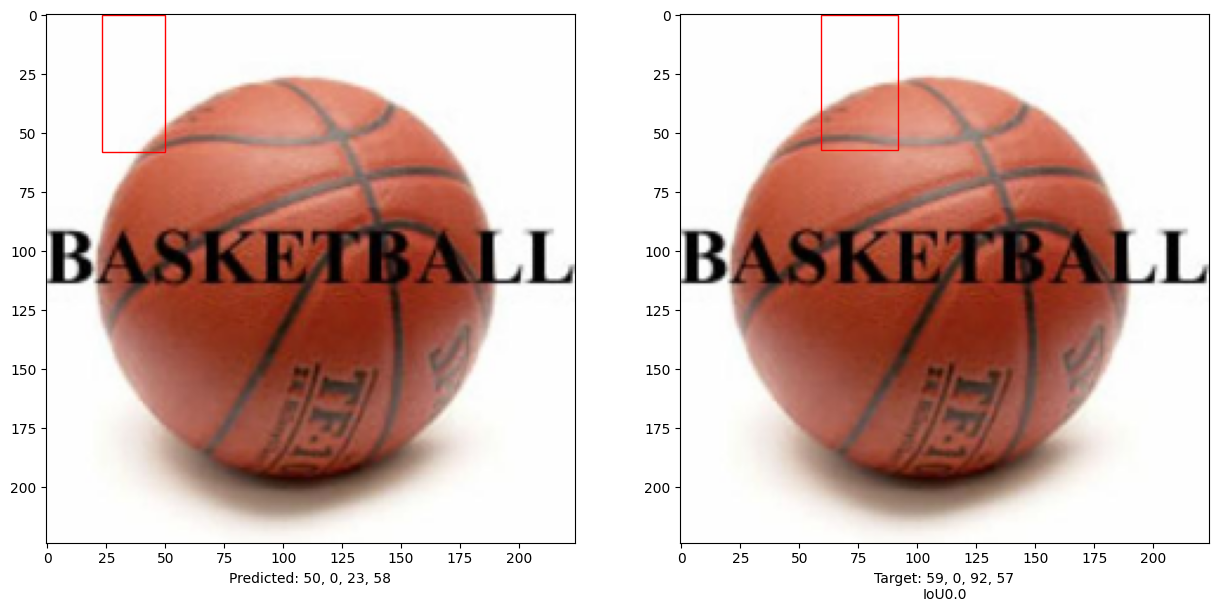

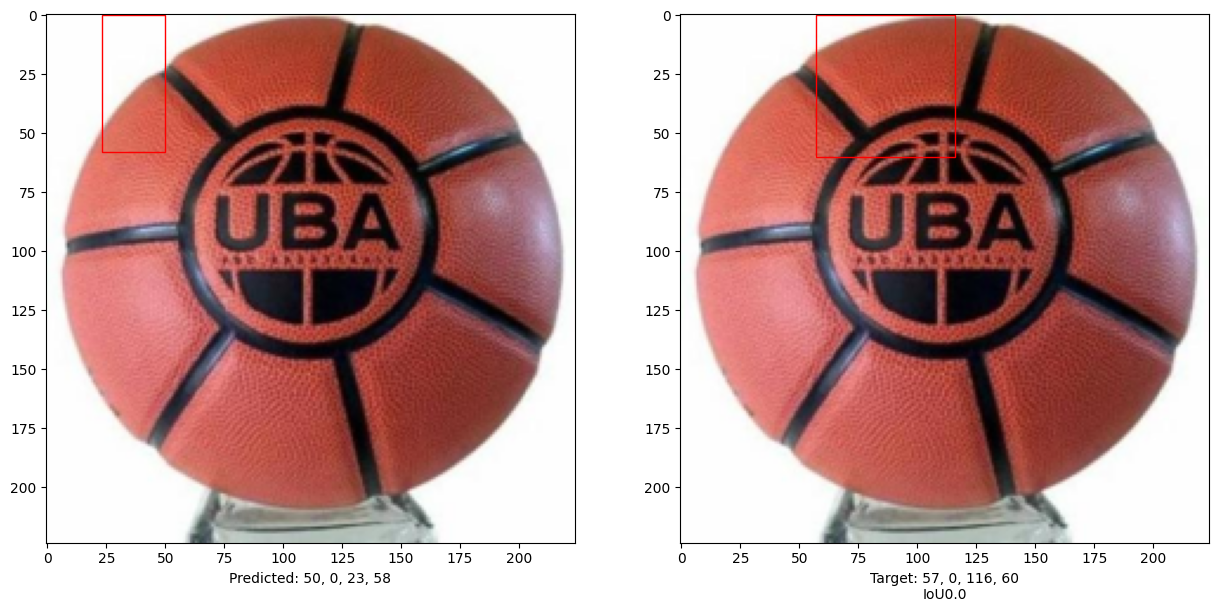

In [ ]:
import matplotlib.patches as patches

# Saves the model in current path
vit_object_detector.save("vit_object_detector.keras")


# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = vit_object_detector.predict(input_image)[0]

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()

This example demonstrates that a pure Transformer can be trained
to predict the bounding boxes of an object in a given image,
thus extending the use of Transformers to object detection tasks.
The model can be improved further by tuning hyper-parameters and pre-training.

In [ ]:
#@title Export to TFLite
vit_object_detector.load_weights("vit_object_detector.weights.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(vit_object_detector)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to the output path
with open('vit_object_detector.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpbkx7vn8i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_270')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133694528464928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133694530580576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133694530574064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133694530569312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133694530581104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133694530583040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133694531587232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133694531586528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133694531589696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133694531587408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1336945315